In [1]:
from qiskit import QuantumCircuit, Aer, execute, IBMQ
from numpy import random
from datetime import datetime
from dotenv import load_dotenv
import os
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

# (a)

### Alice's 4-bit message

In [2]:
random.seed(seed=int(datetime.now().strftime("%f")))

n = 4
alice_bits = random.randint(2, size=n)
alice_msg = ""
for i in range(n):
    alice_msg += str(alice_bits[i])

print(alice_msg)

1101


### Alice sends the message to Bob under the following procedure.

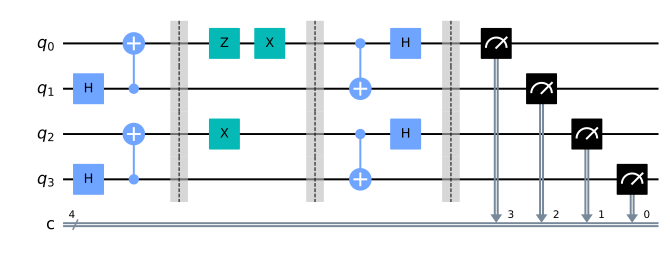

In [3]:
qc = QuantumCircuit(4, 4)

qc.h(1)
qc.h(3)
qc.cx(1, 0)
qc.cx(3, 2)

qc.barrier()

if alice_bits[0]:
    qc.z(0)
if alice_bits[1]:
    qc.x(0)
if alice_bits[2]:
    qc.z(2)
if alice_bits[3]:
    qc.x(2)

qc.barrier()

qc.cx(0, 1)
qc.cx(2, 3)
qc.h(0)
qc.h(2)

qc.barrier()

qc.measure([0, 1, 2, 3], [3, 2, 1, 0])

qc.draw()

### Bob receives the message

In [4]:
simulator = Aer.get_backend('qasm_simulator')
shots = 1

job = execute(qc, simulator, shots=shots, memory=True)
result = job.result()
memory = result.get_memory()
bob_msg = memory[0]
print(bob_msg)

1101


### Let's calculate the SER (symbol error rate) and BER (bit error rate)

In [5]:
correct_symbol = 0
correct_bit = 0

for i in range(int(n/2)):
    if bob_msg[2*i : 2*i+2] == alice_msg[2*i : 2*i+2]:
        correct_symbol += 1
SER = 1 - correct_symbol / (n/2)

for i in range(n):
    if bob_msg[i] == alice_msg[i]:
        correct_bit += 1
BER = 1 - correct_bit / n

print("SER = " + str(SER))
print("BER = " + str(BER))

SER = 0.0
BER = 0.0


### Here, every 2-bit string is a 'symbol’, as they are sent as one package.
### SER $=$ BER here.

# (b)

In [6]:
load_dotenv()
API_TOKEN = os.environ.get("API_TOKEN")

IBMQ.enable_account(API_TOKEN)

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
provider = IBMQ.get_provider('ibm-q')
devices = provider.backends(filters=lambda x: x.configuration().n_qubits >= n
                            and not x.configuration().simulator
                            and x.status().operational==True
                            and x.name()!='ibmq_bogota')
backend = least_busy(devices)
print(backend)

ibmq_santiago


In [8]:
job = execute(qc, backend, shots=shots, memory=True)
job_monitor(job)

Job Status: job has successfully run


In [9]:
result = job.result()
memory = result.get_memory()

bob_msg = memory[0]
print(bob_msg)

1000


In [10]:
correct_symbol = 0
correct_bit = 0

for i in range(int(n/2)):
    if bob_msg[2*i : 2*i+2] == alice_msg[2*i : 2*i+2]:
        correct_symbol += 1
SER = 1 - correct_symbol / (n/2)

for i in range(n):
    if bob_msg[i] == alice_msg[i]:
        correct_bit += 1
BER = 1 - correct_bit / n

print("SER = " + str(SER))
print("BER = " + str(BER))

SER = 1.0
BER = 0.5


### Due to the noise on the real device, the error rates are high.
### SER $>$ BER.

In [11]:
IBMQ.disable_account()